# Make dataset

## 1. Optional: run Inphared to obtain phage FASTA sequences

- Input: nothing
- Output: fasta

In [1]:
make_dataset_output = "data/interim/pharokka/input/50_sequences.fna"

## 2. Run Pharokka on inphared/fasta or in FASTA files

- Input: inphared_fastas / provided fastas
- Output: folder with folders (this assumes parallel processing)

In [92]:
import logging
from logging.handlers import RotatingFileHandler

# Set up basic configuration for logging
log_fmt = '%(asctime)s - %(levelname)s - %(name)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)

# Create a logger
logger = logging.getLogger(__name__)

# Create a file handler that logs even debug messages
file_handler = RotatingFileHandler('my_app.log', maxBytes=10000, backupCount=1)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter(log_fmt))

# Add the file handler to the logger
logger.addHandler(file_handler)

# Now you can log messages
logger.info('This is an info message')
logger.warning('This is a warning message')

2023-11-26 11:39:59,695 - INFO - __main__ - This is an info message
2023-11-26 11:39:59,696 - WARNING - __main__ - This is a warning message


In [1]:
# -*- coding: utf-8 -*-
import argparse
import logging
from logging.handlers import RotatingFileHandler
from datetime import datetime
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd

def main(input_data_filepath, output_filepath):
    """ Runs data processing scripts to turn raw data from (../raw) into
        cleaned data ready to be analyzed (saved in ../processed).
    """
    logger = logging.getLogger(__name__)
    logger.info('-> Start of Make Dataset <-')
    print("works")



if __name__ == '__main__':
    # Set up basic configuration for logging
    log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logging.basicConfig(level=logging.INFO, format=log_fmt)

    # Get current date
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Create a logger
    logger = logging.getLogger(__name__)

    # Create a file handler that logs even debug messages with the current date in filename
    log_filename = f'my_app_{current_date}.log'
    file_handler = RotatingFileHandler(log_filename, maxBytes=10000, backupCount=1)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(logging.Formatter(log_fmt))

    # Add the file handler to the logger
    logger.addHandler(file_handler)

    # not used in this stub but often useful for finding various files
    # project_dir = Path(__file__).resolve().parents[2]

    # find .env automagically by walking up directories until it's found, then
    # load up the .env entries as environment variables
    # load_dotenv(find_dotenv())

    # Create the parser
    parser = argparse.ArgumentParser(description="Data processing script")

    # Add arguments
    parser.add_argument(input_data_filepath, '../data/interim/pharokka/10_folders', type=str, help="Path to the input data file")
    parser.add_argument(output_filepath, '../data/test/', type=str, help="Path to the output file")

    # Parse the arguments
    args = parser.parse_args()

    # Call main function with parsed arguments
    main(args.input_data_filepath, args.output_filepath)


usage: ipykernel_launcher.py [-h]
                             ../data/interim/pharokka/10_folders ../data/test/
ipykernel_launcher.py: error: the following arguments are required: ../data/interim/pharokka/10_folders, ../data/test/


SystemExit: 2

/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Build_features

In [1]:
import pandas as pd
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
from Bio.Seq import UndefinedSequenceError
import argparse
import os
import subprocess
import numpy as np

# 3. Parse Pharokka files

- Input: Folder with folders of pharokka
- Output: csv file with engineered features

In [162]:
parser = argparse.ArgumentParser(description="Parses Pharokka output folders.")
optional = parser._action_groups.pop()
required = parser.add_argument_group('required arguments')
parser.add_argument("-d", "--data", type=str, required=True,
                    help="Path to the data. Accepted inputis a directory path to an already processed Pharokka output, \
                        where the results for each phage are contained in an individual folder.")
optional.add_argument("-s","--staining", dest="staining", action='store', 
                        default='data/interim/gram_staining/staining_assignation.csv', 
                        help="Path to csv file with a customised gram staining class assignation for every entry.")
optional.add_argument("-o","--output_directory", dest="output", action='store', 
                        default='data/processed/model_data_pharokka.csv', help="Output path (default: data/processed/model_data_pharokka.csv).")
optional.add_argument("-p","--pharokka_directory", dest="pharokka", action='store', 
                        default="/mnt/c/Users/Alvaro/Desktop/pharokka_output/", help="Path where pharokka output will be stored (default: /mnt/c/Users/Alvaro/Desktop/pharokka_output/).")
optional.add_argument("-b","--database_directory", dest="database", action='store', 
                        default="/mnt/c/Users/Alvaro/Desktop/pharokka_database/", help="Path to the Pharokka database (default./mnt/c/Users/Alvaro/Desktop/pharokka_database/).")
args = parser.parse_args()

'''
Inputs:
- Pharokka output folder with the results for each phage contained in their own individual folder.

This output will be the input for the engineer features and staining feature, and its
output is stored in args.output. This output is used by train_model.py for training.

'''

usage: ipykernel_launcher.py [-h] -d DATA [-s STAINING] [-o OUTPUT]
                             [-p PHAROKKA] [-b DATABASE]
ipykernel_launcher.py: error: the following arguments are required: -d/--data


SystemExit: 2

/home/alvaroguleon/miniconda3/envs/phage/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [17]:
def engineer_features(folder):
    # Read data from the TSV file
    df = pd.read_csv(f'{folder}/pharokka_top_hits_mash_inphared.tsv', sep='\t')

    # Select only the columns you need
    selected_columns = [
        'Accession', 'contig','Genome_Length_(bp)', 'molGC_(%)', 'Molecule',
        'Number_CDS', 'Positive_Strand_(%)', 'Negative_Strand_(%)',
        'Coding_Capacity_(%)', 'tRNAs', 'Host', 
        'Isolation_Host_(beware_inconsistent_and_nonsense_values)'
    ]
    df = df[selected_columns]

    # Rename columns to match your previous DataFrame structure
    df = df.rename(columns={
        'Accession': 'id_inphared',
        'contig': 'contig_inphared',
        'Genome_Length_(bp)': 'genome_length_inphared',
        'molGC_(%)': 'gc_%_inphared',
        'Molecule': 'molecule_inphared_type',
        'Number_CDS': 'cds_number_inphared',
        'Positive_Strand_(%)': 'positive_strand_%_inphared',
        'Negative_Strand_(%)': 'negative_strand_%_inphared',
        'Coding_Capacity_(%)': 'coding_capacity_inphared',
        'tRNAs': 'tRNAs_inphared',
        'Host': 'host_inphared',
        'Isolation_Host_(beware_inconsistent_and_nonsense_values)': 'isolation_host_inphared'
    })

    # Initialize lists for storing data
    ids = []
    topologies = []
    sequences = []

    # Read the GenBank file for topology and sequences
    genbank_file = f'{folder}/pharokka.gbk'
    for record in SeqIO.parse(genbank_file, "genbank"):
        ids.append(record.id)    
        topologies.append(record.annotations.get('topology', 'N/A'))
        sequences.append(str(record.seq))


    # These lines use the "contig" column of inphared tsv when the "Accession" is wrong (does not match the one in Genbank file?)
    genbank_id = ids[0] if ids else None

    # Update Accession value based on the logic described
    for index, row in df.iterrows():
        if row['id_inphared'] != genbank_id and row['contig_inphared'] == genbank_id:
            print(f"Updating Accession for folder {folder}: from {row['id_inphared']} to {genbank_id}")
            df.at[index, 'id_inphared'] = genbank_id



    # Create DataFrames from the topologies and sequences
    topology_df = pd.DataFrame({'id_inphared': ids, 'topology': topologies})
    sequence_df = pd.DataFrame({'id_inphared': ids, 'sequence': sequences})

    # Merge the TSV data with the GenBank topology and sequence data
    df = pd.merge(df, topology_df, on='id_inphared', how='left')
    df = pd.merge(df, sequence_df, on='id_inphared', how='left')
    del(topology_df)
    del(sequence_df)

    # Check for unexpected molecule types
    expected_molecule_types = ['ss-DNA', 'DNA', 'RNA', 'ss-RNA']

    # Check and correct 'cRNA' entries
    cRNA_entries = df[df['molecule_inphared_type'] == 'cRNA']
    if not cRNA_entries.empty:
        for entry_id in cRNA_entries['id_inphared']:
            print(f"Info: Entry with id '{entry_id}' has molecule type 'cRNA'. Changing it to 'RNA'.")
        df.loc[df['molecule_inphared_type'] == 'cRNA', 'molecule_inphared_type'] = 'RNA'

    # Check and correct 'cDNA' entries
    cDNA_entries = df[df['molecule_inphared_type'] == 'cDNA']
    if not cDNA_entries.empty:
        for entry_id in cDNA_entries['id_inphared']:
            print(f"Info: Entry with id '{entry_id}' has molecule type 'cDNA'. Changing it to 'DNA'.")
        df.loc[df['molecule_inphared_type'] == 'cDNA', 'molecule_inphared_type'] = 'DNA'

    unexpected_types = set(df['molecule_inphared_type']) - set(expected_molecule_types)

    if unexpected_types:
        for utype in unexpected_types:
            # Get ids of entries with the unexpected molecule type
            ids_to_exclude = df[df['molecule_inphared_type'] == utype]['id_inphared'].tolist()
            for entry_id in ids_to_exclude:
                print(f"Warning: Entry with id '{entry_id}' has unrecognized molecule type '{utype}'. It will not be considered.")
            df = df[df['molecule_inphared_type'] != utype]
            
    df = pd.get_dummies(df, columns=['molecule_inphared_type'])
    df = pd.get_dummies(df, columns=['topology'])
    expected_columns = ['jumbophage_inphared', 'topology_linear','topology_circular',
    'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_DNA', 'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA']
    
    for col in expected_columns:
        if col not in df.columns:
            df[col] = 0  # Filling with zeros
        df[col] = df[col].astype(bool)  # Convert to boolean

    df['jumbophage_inphared'] = df['genome_length_inphared'].apply(lambda x: x >= 200000)
    df['jumbophage_inphared'] = df['jumbophage_inphared'].astype(int)  # Convert True/False to 1/0
    

    df_length_gc_cds_density = pd.read_csv(f"{folder}/pharokka_length_gc_cds_density.tsv", sep="\t")
    df_length_gc_cds_density['contig'] = df_length_gc_cds_density['contig'].str.slice(0,8)
    df_length_gc_cds_density

    df = pd.merge(df, df_length_gc_cds_density, left_on='id_inphared', right_on='contig', how='outer')
    del(df_length_gc_cds_density)

    df_cds = pd.read_csv(f"{folder}/pharokka_cds_functions.tsv", sep="\t")
    
    # Define a dictionary of replacements
    replacements = {
        "DNA, RNA and nucleotide metabolism":"nucleotide_metabolism",
        "head and packaging": "head_packaging",
        "moron, auxiliary metabolic gene and host takeover": "host_takeover",
        "transcription regulation": "transcription",
        "unknown function": "unkown_function"
    }

    # Replace the values using the dictionary
    df_cds['Description'] = df_cds['Description'].replace(replacements)

    df_cds = df_cds.pivot(index='contig', columns='Description', values='Count').reset_index()
    df_cds['contig'] = df_cds['contig'].str.slice(0,8)

    df = pd.merge(df, df_cds, left_on='id_inphared', right_on='contig', how='outer')
    del(df_cds)


    df_frame = pd.read_csv(f"{folder}/pharokka_cds_final_merged_output.tsv", sep="\t",  low_memory=False)

    frame_counts = df_frame.groupby('contig')['frame'].value_counts().unstack(fill_value=0)

    # Ensure both '+' and '-' columns are present
    frame_counts['+'] = frame_counts.get('+', 0)
    frame_counts['-'] = frame_counts.get('-', 0)

    # Rename columns explicitly
    frame_counts = frame_counts.rename(columns={'+': 'frame_positive', '-': 'frame_negative'})

    # Reset index if needed
    frame_counts = frame_counts.reset_index()
    frame_counts = frame_counts.rename_axis(None, axis=1).reset_index()
    frame_counts['contig'] = frame_counts['contig'].str.slice(0,8)
    df = pd.merge(df, frame_counts, left_on='id_inphared', right_on='contig', how='outer')

    df = df.rename(columns={'id_inphared': 'id'})
    df['dummy_index'] = 0

    # Group by the dummy index and aggregate using 'first'
    df = df.groupby('dummy_index').first()

    # Reset the index
    df = df.reset_index(drop=True)

    columns = ['id','host_inphared','isolation_host_inphared','genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'tRNAs_inphared', 'host_inphared',
       'isolation_host_inphared', 'molecule_inphared_type_DNA',
       'topology_linear', 'jumbophage_inphared', 'topology_circular',
       'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA',  'length', 'gc_perc',
       'transl_table', 'cds_coding_density',  'CARD_AMR_Genes',
       'CDS', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
        #'contig_x', 'contig', 'contig_y',
       'transcription', 'unkown_function', 'frame_positive',
       'frame_negative', 'sequence']
    

    df = df[columns]
    return df

def staining_feature(staining_df, features_df):
    stain = pd.read_csv(staining_df, index_col = 0)
    stain = stain[['Accession', 'staining']]
    stain = stain.rename(columns={'Accession': 'id'})

    features_df = pd.merge(features_df, stain, on='id', how='left')
    # columns = ['id','staining','host_inphared','isolation_host_inphared','genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
    #    'positive_strand_%_inphared', 'negative_strand_%_inphared',
    #    'coding_capacity_inphared', 'tRNAs_inphared', 'host_inphared',
    #    'isolation_host_inphared', 'molecule_inphared_type_DNA',
    #    'topology_linear', 'jumbophage_inphared', 'topology_circular',
    #    'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_RNA',
    #    'molecule_inphared_type_ss-RNA',  'length', 'gc_perc',
    #    'transl_table', 'cds_coding_density',  'CARD_AMR_Genes',
    #    'CDS', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
    #    'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
    #    'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
    #     #'contig_x', 'contig', 'contig_y',
    #    'transcription', 'unkown_function', 'frame_positive',
    #    'frame_negative', 'sequence']


    return features_df

In [4]:
'''args_data = '../data/interim/pharokka/10_folders/'  # Replace with your main folder path
args_data = '../data/interim/pharokka/pharokka_full_output/'  # Replace with your main folder path
output_csv = '../data/test/test_engineer_features.csv'

print("-> Starting Feature Engineering ----------------------")
# Delete the output CSV file if it already exists
if os.path.exists(output_csv):
    print("Output file already exists. Overwriting it...")
    os.remove(output_csv)
    
if os.path.isdir(args_data):
    # The input is a directory; process all relevant files within
    print(f"Processing Pharokka phage in directory: {args_data}")
    # Check if output CSV file exists, if not create it
    if not os.path.exists(output_csv):
        with open(output_csv, 'w') as f:
            pass

    # Iterate over each folder in the main folder
    for folder in os.listdir(args_data):
        folder_path = os.path.join(args_data, folder)
        
    # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Check if "pharokka.gbk" file exists in the folder
            if "pharokka.gbk" in os.listdir(folder_path):
                print(f"Processing {folder_path}...")
                # Pass the full path of "pharokka.gbk" to your function and get the dataframe
                df = engineer_features(folder_path)

                # Append the dataframe to the CSV file
                with open(output_csv, 'a') as f:
                    df.to_csv(f, header=f.tell()==0, index=False)
            else:
                print(f"Skipped {folder_path}: 'pharokka.gbk' file not found or not a directory")

# Print completion message
print(f"Feature engineering completed and data stored to CSV in {output_csv}.")'''

-> Starting Feature Engineering ----------------------
Output file already exists. Overwriting it...
Processing Pharokka phage in directory: ../data/interim/pharokka/pharokka_full_output/
Processing ../data/interim/pharokka/pharokka_full_output/sequence_001.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_002.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_003.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_004.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_005.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_006.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_007.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_008.fasta.pharokka...
Processing ../data/interim/pharokka/pharokka_full_output/sequence_009.fasta.pharokka...
Processing ../data/i

In [15]:
def process_pharokka_output(args_data, output_csv):
    # Check if output CSV file exists, if not create it
    if not os.path.exists(output_csv):
        with open(output_csv, 'w') as f:
            pass

    # Iterate over each folder in the main folder
    for folder in os.listdir(args_data):
        folder_path = os.path.join(args_data, folder)

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Check if "pharokka.gbk" file exists in the folder
            if "pharokka.gbk" in os.listdir(folder_path):
                print(f"Processing {folder_path}...")
                # Pass the full path of "pharokka.gbk" to your function and get the dataframe
                df = engineer_features(folder_path)

                # Append the dataframe to the CSV file
                with open(output_csv, 'a') as f:
                    df.to_csv(f, header=f.tell()==0, index=False)
            else:
                print(f"Skipped {folder_path}: 'pharokka.gbk' file not found or not a directory")

args_data = '../data/interim/pharokka/10_folders/'  # Replace with your main folder path  # Replace with your main folder path
output_csv = '../data/test/test10_engineer_features.csv'

print("-> Starting Feature Engineering ----------------------")
# Delete the output CSV file if it already exists
if os.path.exists(output_csv):
    print("Output file already exists. Overwriting it...")
    os.remove(output_csv)
    
if os.path.isdir(args_data):
    print(f"Processing Pharokka phages in directory: {args_data}")
    process_pharokka_output(args_data, output_csv)

# Print completion message
print(f"Feature engineering completed and data stored to CSV in {output_csv}.")

-> Starting Feature Engineering ----------------------
Processing Pharokka phages in directory: ../data/interim/pharokka/10_folders/
Processing ../data/interim/pharokka/10_folders/sequence_16443.fasta.pharokka...


NameError: name 'engineer_features' is not defined

## 3.5 Filter out unwanted sequences for training

In [2]:
import pickle
import pandas as pd

- Input: df with engineered features but unfiltered 
- Output: df with engineered features filtered out

In [27]:
df = pd.read_csv('../data/test/test_engineer_features.csv')
print("Shape before filtering", df.shape)

Shape before filtering (26286, 42)


In [28]:
# Saving discarded phages in csv
discarded = df[(df['host_inphared'] == 'Unspecified') | (df['isolation_host_inphared'] == 'Unspecified')]

In [29]:
df = df[df['host_inphared'] != "Unspecified"] 
print("Shape after filtering unspecified hosts", df.shape)
df = df[df['isolation_host_inphared'] != "Unspecified"]
print("Shape after filtering unspecified isolation hosts", df.shape)


Shape after filtering unspecified hosts (23421, 42)
Shape after filtering unspecified isolation hosts (14416, 42)


In [30]:
# Only keep first two strings in each row of Isolation Host to reduce name incompatibilities
# Split each value on space and select the first two elements
df['isolation_host_inphared'] = df['isolation_host_inphared'].str.split().str[:2].str.join(' ')

# Fixing mispelled genera, wrong taxonomy, etc
df['host_inphared'] = df['host_inphared'].replace('Enteroccous', 'Enterococcus')
df.loc[df['isolation_host_inphared'] == 'Salmonella enterica', 'host_inphared'] = 'Salmonella'
df.loc[df['isolation_host_inphared'] == 'Salmonella typhimurium', 'host_inphared'] = 'Salmonella'
df.loc[df['isolation_host_inphared'] == 'Escherichia coli', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'E. coli', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'Escherichia coli,', 'host_inphared'] = 'Escherichia'
df.loc[df['isolation_host_inphared'] == 'Shigella flexneri', 'host_inphared'] = 'Shigella'

## 4. Assign gram staining 

- Input: df with engineered features
- Output: df with engineered features + staining feature

In [31]:
print("-> Starting Gram Staining Assignation ----------------------")
# Excluding genera and species with unclear gram staining
exclude_genus = ['Clostridium', 'Neobacillus', 'Alteribacter', 'Desulfotomaculum', 'Caloramator', 'Desulforamulus', 'Heyndrickxia', 'Peptoclostridium', 'Thermoanaerobacter', 'Thermoanaerobacterium', 'Aureimonas', 'Actinomadura', 'Alkalibacterium', 'Deinococcus', 'Tepidibacillus', 'Sphingomonas', 'Lysinibacillus', 'Ruminiclostridium', 'Caldicellulosiruptor', 'Pseudomonas', 'Streptococcus', 'Microlunatus', 'Streptomyces', 'Butyricimonas', 'Halalkalibacter', 'Chelativorans', 'Natrinema', 'Ureibacillus', 'Clostridioides', 'Desulfosporosinus', 'Lacibacter', 'Nocardioides', 'Siminovitchia', 'Belliella', 'Tistlia', 'Actinoplanes', 'Paenibacillus', 'Vallitalea', 'Actinotalea', 'Cohnella', 'Rhizobium', 'Anaerotignum', 'Cellulomonas', 'Flavobacterium', 'Bacillus', 'Nesterenkonia']
exclude_species = ['Ureibacillus massiliensis', 'Tistlia consotensis', 'Clostridioides difficile', 'Vallitalea guaymasensis', 'Belliella pelovolcani', 'Actinotalea ferrariae']

# Save the discarded dataframe
excluded_rows = df[df['host_inphared'].isin(exclude_genus) | df['isolation_host_inphared'].isin(exclude_species)]

# Append the excluded rows to the discarded DataFrame
discarded = pd.concat([discarded, excluded_rows], ignore_index=True)
del(excluded_rows)

print("Shape of the dataframe before deleting the unclear genera: ", df.shape)
df = df[~df['host_inphared'].isin(exclude_genus)]
print("Shape of the dataframe after deleting the unclear genera: ", df.shape)
df = df[~df['isolation_host_inphared'].isin(exclude_species)]
shape1 = df.shape
print("Shape of the dataframe after deleting the unclear species: ", shape1)


-> Starting Gram Staining Assignation ----------------------
Shape of the dataframe before deleting the unclear genera:  (14416, 42)
Shape of the dataframe after deleting the unclear genera:  (11467, 42)
Shape of the dataframe after deleting the unclear species:  (11467, 42)


In [32]:
# Loading default gram staining mapping
all_gram = pd.read_csv("../data/interim/gram_staining/exploration/all_gram_stains_fixed_species.csv")
print("All gram shape, ",all_gram.shape)

# First mapping: from Species to Isolation host
# Create a mapping dictionary from species to Gram stain
species_to_stain = dict(zip(all_gram['species'], all_gram['Gram stain']))


# Use the mapping to create the 'staining' column in df
df['staining'] = df['isolation_host_inphared'].map(species_to_stain)
print(df.shape)
drop = df.dropna(subset=['staining'])
shape2 = drop.shape

print("Percentage of phages assigned a class based solely on species: ", str(shape2[0]/shape1[0]*100))


All gram shape,  (7541, 3)
(11467, 43)
Percentage of phages assigned a class based solely on species:  22.17668091043865


In [33]:
# Second mapping: From Genus to Host 
genus_to_stain = dict(zip(all_gram['Genus'], all_gram['Gram stain']))

# Use the mapping to create the 'staining' column in df
df['staining'] = df['host_inphared'].map(genus_to_stain)
print(df.shape)
drop = df.dropna(subset=['staining'])
shape3 = drop.shape
print(shape3)
print("Percentage of phages assigned a class using species+genus: ", str(shape3[0]/shape1[0]*100))

(11467, 43)
(9495, 43)
Percentage of phages assigned a class using species+genus:  82.80282549925874


In [34]:
# Remaining phages which are unmapped
remaining = df[(df["staining"] != "positive") & (df["staining"] != "negative")]
print("The number of unclassified phages in this first round of mapping is", remaining.shape[0])

with open('../data/interim/gram_staining/updated_gram_pos_neg_dict.pkl', 'rb') as file:
    phage_dict = pickle.load(file)

file.close()

# Create a new genus_to_stain with updated values
phage_dict = {key: 'negative' if value == 'neg' else 'positive' for key, value in phage_dict.items()}

# Iterate through the DataFrame
for index, row in df.iterrows():
    if pd.isna(row['staining']):  # Check if 'staining' column is NaN
        host = row['host_inphared']
        if host in phage_dict:
            df.at[index, 'staining'] = phage_dict[host]

drop = df.dropna(subset=['staining'])
shape4 = drop.shape
print("Percentage of phages assigned a class using species+genus+extra dict: ", str(shape4[0]/shape1[0]*100))

if str(shape4[0]/shape1[0]*100) != "100.0":
    print("The number of unclassified phage Hosts is",len(remaining["host_inphared"].unique().tolist()))
    print("The unclassified Hosts are:",remaining["host_inphared"].unique().tolist())
    print()
    print("The number of unclassified phage Iolation Hosts is",len(remaining["isolation_host_inphared"].unique().tolist()))
    print("The unclassified Isolation Hosts are:",remaining["isolation_host_inphared"].unique().tolist())

else:
    print("All input phages have been successfully assigned a Gram staining class.")

del(remaining)

The number of unclassified phages in this first round of mapping is 1972
Percentage of phages assigned a class using species+genus+extra dict:  97.17450074125752
The number of unclassified phage Hosts is 86
The unclassified Hosts are: ['Salmonella', 'Spiroplasma', 'Brochothrix', 'Synechococcus', 'Pelagibacter', 'Plectonema', 'Verrucomicrobia', 'Microcystis', 'Sulfolobus', 'Cedecea', 'Janthinobacterium', 'Elizabethkingia', 'Citromicrobium', 'Kurthia', 'Liberibacter', 'Sphaerotilus', 'Lokiarchaeota', 'Raoultella', 'Nostoc', 'Chlamydia', 'Pararheinheimera', 'Edwardsiella', 'Lentibacter', 'Cylindrospermopsis', 'Lentisphaerae', 'Phormidium', 'Morganella', 'Mycoplasma', 'Hamiltonella', 'Myxococcus', 'Solobacterium', 'Wolbachia', 'Arthronema', 'Methanocaldococcus', 'Buttiauxella', 'Oenococcus', 'Pseudanabaena', 'Pyrobaculum', 'Metallosphaera', 'Acidianus', 'Saccharolobus', 'Butyrivibrio', 'Thermoproteus', 'Sinorhizobium', 'Salinibacter', 'Methanosarcina', 'Curvibacter', 'Nodularia', 'Enteroba

In [35]:
# Step 1: Replace NaN values with "remove"
df['staining'].fillna('remove', inplace=True)

# Step 2: Separate removed rows and update df_mapped
removed = df[df['staining'] == "remove"]
print("Number of entries removed due to NaN in staining", removed.shape)
df = df[df['staining'] != "remove"]
print(df.shape)

# Calculate the percentage of removed phages
print("Percentage of phages removed due to unclear genera in the last step: ", str(removed.shape[0] / shape1[0] * 100))

# Step 3: Append the removed rows to the discarded DataFrame
# Assuming discarded is defined earlier in your code
discarded = pd.concat([discarded, removed.drop('staining', axis=1)], ignore_index=True)

discarded_output = '../data/test/discarded.csv'

# Delete the output CSV file if it already exists
if os.path.exists(discarded_output):
    os.remove(discarded_output)

print(f"{discarded[discarded.isna().any(axis=1)].shape[0]} unclassified phages have not been stored in the discarded dataframe because they contained null values. ")
discarded.dropna(inplace=True)
print(f"Saving discarded data into a csv in {discarded_output}...")
discarded.to_csv(discarded_output,  index=False)

Number of entries removed due to NaN in staining (324, 43)
(11143, 43)
Percentage of phages removed due to unclear genera in the last step:  2.8254992587424788
96 unclassified phages have not been stored in the discarded dataframe because they contained null values. 
Saving discarded data into a csv in ../data/test/discarded.csv...


In [19]:
# Removiong Host and Isolation Host
df = df[['id', 'staining',
       'genome_length_inphared', 'gc_%_inphared', 'cds_number_inphared',
       'positive_strand_%_inphared', 'negative_strand_%_inphared',
       'coding_capacity_inphared', 'tRNAs_inphared',  'molecule_inphared_type_DNA',
       'topology_linear', 'jumbophage_inphared', 'topology_circular',
       'molecule_inphared_type_ss-DNA', 'molecule_inphared_type_RNA',
       'molecule_inphared_type_ss-RNA', 'length', 'gc_perc', 'transl_table',
       'cds_coding_density', 'CARD_AMR_Genes', 'CDS', 'CRISPRs',
       'VFDB_Virulence_Factors', 'connector', 'head_packaging',
       'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative',
       'sequence' ]]

stain_output = "../data/test/features_with_gram_class.csv"
df.to_csv(stain_output, index=False)
print(f"---Gram staining assignation has been completed, and the data is stored in {stain_output}")

---Gram staining assignation has been completed, and the data is stored in ../data/test/features_with_gram_class.csv


# Train_model py

## 5. Training a model

- Input: df with engineered features + staining feature
- Output: trained_model pickle + training metrics/plots

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score,  log_loss, mean_squared_error, balanced_accuracy_score
from math import sqrt
import os
import subprocess
import shutil
from concurrent.futures import ProcessPoolExecutor, as_completed
import networkx as nx
from networkx.algorithms import community
import random

In [5]:
def matthews(y_true, y_pred):
    """
    Calculate the Matthews Correlation Coefficient and other metrics.
    """
    if type(y_true) == pd.Series:
        y_true = y_true.values

    P = len([x for x in y_true if x == 1])
    N = len([x for x in y_true if x == 0])

    Tp, Fp = 0, 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1: Tp += 1
        elif y_true[i] == 0 and y_pred[i] == 1: Fp += 1

    Tn = N - Fp
    Fn = P - Tp

    try:
        mcc = (Tp * Tn - Fp * Fn) / sqrt(
            (Tn + Fn) * (Tn + Fp) * (Tp + Fn) * (Tp + Fp))
    except ZeroDivisionError:
        mcc = 0

    return (mcc, f" \n \
    P: {P:_} \n \
    Tp: {Tp:_} \n \
    Fp: {Fp:_} \n \
    N: {N:_} \n \
    Tn: {Tn:_} \n \
    Fn: {Fn:_}")

In [10]:
print("-> Starting Training of Model ----------------------")

df = pd.read_csv("../data/test/features_with_gram_class.csv")
df.shape

-> Starting Training of Model ----------------------


(11143, 39)

In [13]:
11143+148+86

11377

### 5.1 Mash Distances and Clustering functions

In [6]:
print ("-- Clustering phages by DNA sequence with MASH...")
# Obtaining sequences
genomes = {}

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    genomes[row['id']] = row['sequence']

def unix_call(command):
    result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return result.stdout.decode('utf-8')  # Decode stdout to string

def mash_dist_pair(file_1, file_2):
    command = f"mash dist {file_1} {file_2}"
    try:
        dist_output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        result = dist_output.decode('utf-8').strip()

        # Parse the output to extract shared hashes and total hashes
        parts = result.split('\t')  # Split the mash output into parts
        shared_hashes_info = parts[4]  # Get the shared hashes information, e.g., "1/1000"
        shared, total = map(int, shared_hashes_info.split('/'))  # Split into shared and total hashes
        identity = (shared / total) * 100 if total > 0 else 0  # Calculate identity percentage

        # Return the result with identity percentage added
        return (os.path.splitext(os.path.basename(file_1))[0],  # Genome1 ID
                os.path.splitext(os.path.basename(file_2))[0],  # Genome2 ID
                parts[2],  # Distance
                parts[3],  # P-value
                shared_hashes_info,  # Shared-hashes
                identity)  # Identity percentage

    except subprocess.CalledProcessError as e:
        error_message = f"Error: {e.output.decode()}"
        # Provide a formatted error tuple consistent with the successful output
        return (os.path.splitext(os.path.basename(file_1))[0],
                os.path.splitext(os.path.basename(file_2))[0],
                parts[2],  # Distance
                parts[3],  # P-value
                shared_hashes_info,  # Shared-hashes
                identity)  # Identity percentage
    
def cluster_genomes(genomes, create_sketch=True, batch_size = 500):
    temp_dir = '/home/alvaroguleon/temp_mash'
    sketch_files = []
    
    # Check if temp_dir already exists and has files
    if os.path.exists(temp_dir) and os.path.isdir(temp_dir):
        # Check if the directory has sketch files or fasta files depending on create_sketch flag
        existing_files = os.listdir(temp_dir)
        for genome_id in genomes.keys():
            expected_file = f"{genome_id}.msh" if create_sketch else f"{genome_id}.fna"
            if expected_file in existing_files:
                sketch_files.append(os.path.join(temp_dir, expected_file))
            else:
                # If expected files are not found, they need to be created
                print(f"Expected file {expected_file} not found in {temp_dir}.")
                # Set flag to indicate file creation is required
                create_files = True
                break
        else:
            # Set flag to indicate no file creation is required if all files were found
            create_files = False
    else:
        # If the directory doesn't exist, create it and set flag to create files
        os.makedirs(temp_dir, exist_ok=True)
        create_files = True

    if create_files:
        print("Producing temporary files for MASH...")
        # print("FASTA files are being created")

        # Create FASTA or sketch files if needed
        for genome_id, sequence in genomes.items():
            file_path = os.path.join(temp_dir, f"{genome_id}.fna")
            with open(file_path, 'w') as file:
                file.write(f">{genome_id}\n{sequence}\n")
            
            if create_sketch:
                sketch_prefix = file_path.replace('.fna', '')  # Remove the '.fna' for mash output prefix
                # print(f"Sketch files are being created for {sketch_prefix} {file_path}")
                unix_call(f"mash sketch -o {sketch_prefix} {file_path}")
                sketch_files.append(sketch_prefix + '.msh')  # Append the .msh path
            else:
                sketch_files.append(file_path)  # Append the .fna path

    pairs = [(sketch_files[i], sketch_file) for i in range(len(sketch_files)) for sketch_file in sketch_files[i + 1:]]
    

    with ProcessPoolExecutor() as executor, open('../data/test/test_mash_distances.csv', 'w') as output_file:
        output_file.write('Genome1,Genome2,Distance,P-value,Shared-hashes,Identity\n')  # Update the header with the new column
        for batch_start in range(0, len(sketch_files), batch_size):
            batch_end = min(batch_start + batch_size, len(sketch_files))
            batch_pairs = [(sketch_files[i], sketch_file) for i in range(batch_start, batch_end) for sketch_file in sketch_files[i+1:batch_end]]
            
            futures = {executor.submit(mash_dist_pair, pair[0], pair[1]): pair for pair in batch_pairs}
            for future in as_completed(futures):
                file_1, file_2, distance, p_value, shared_hashes, identity = future.result()  # Update to receive identity
                if not distance.startswith("Error"):  # Only write if no error occurred
                    # Write including the new identity percentage
                    output_file.write(f"{file_1},{file_2},{distance},{p_value},{shared_hashes},{identity:.2f}\n")
            # Print the completion message for the batch
            print(f"Completed processing batch from {batch_start} to {batch_end - 1}")

    shutil.rmtree(temp_dir)  # Clean up temporary directory
    print("**MASH clustering completed**")
    return pd.read_csv('../data/test/test_mash_distances.csv')


args_distance= '../data/test/test_mash_distances.csv'
args_distance = None
if args_distance is None:
    distances = cluster_genomes(genomes, create_sketch=True, batch_size = 10)
    
else:
    distances = pd.read_csv(args_distance)
    print("Already existing distances have been processed.")

-- Clustering phages by DNA sequence with MASH...
Producing temporary files for MASH...
Completed processing batch from 0 to 9
Completed processing batch from 10 to 19
Completed processing batch from 20 to 29
Completed processing batch from 30 to 39
Completed processing batch from 40 to 49
Completed processing batch from 50 to 59
Completed processing batch from 60 to 69
Completed processing batch from 70 to 79
Completed processing batch from 80 to 89
Completed processing batch from 90 to 99
Completed processing batch from 100 to 109
Completed processing batch from 110 to 119
Completed processing batch from 120 to 129
Completed processing batch from 130 to 139
Completed processing batch from 140 to 149
Completed processing batch from 150 to 159
Completed processing batch from 160 to 169
Completed processing batch from 170 to 179
Completed processing batch from 180 to 189
Completed processing batch from 190 to 199
Completed processing batch from 200 to 209
Completed processing batch from

In [39]:
distances = pd.read_csv('../data/test/test_mash_distances.csv')


In [40]:
# from src.visualization.visualize import plot_network
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

def plot_network(df, communities, path_to_save='../data/test/reports/figures/phage_network.png'):
    print("-- Creating cluster map with NetworkX...")

    # Getting color for the nodes based on majority 'staining' in the community
    staining_map = df[["id", "staining"]].set_index('id')['staining'].to_dict()

    # Determine the majority class for each community
    community_staining = {}
    for community_number, community in enumerate(communities, start=1):
        staining_counts = {'positive': 0, 'negative': 0}
        for node in community:
            if node in staining_map:  # Count only if staining is known
                staining_counts[staining_map[node]] += 1
        majority_staining = max(staining_counts, key=staining_counts.get, default='negative')
        community_staining[community_number] = majority_staining

    # Calculate positions for all nodes to be used in plotting
    pos = nx.spring_layout(G, seed=42)  # Using a fixed seed for reproducibility

    # Setup figure
    plt.figure(figsize=(20, 20))

    # Draw all edges first to avoid redrawing
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

    # Draw nodes in batches based on community staining
    for community_index, community_nodes in enumerate(communities, start=1):
        color = 'blue' if community_staining[community_index] == 'positive' else 'red'
        nx.draw_networkx_nodes(G, pos, nodelist=list(community_nodes), node_color=color, node_size=50, alpha=0.5)

    # Draw community labels
    for community_index, community_nodes in enumerate(communities, start=1):
        representative_node = next(iter(community_nodes))
        plt.text(pos[representative_node][0], pos[representative_node][1], str(community_index),
                 horizontalalignment='center', verticalalignment='center',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='black', boxstyle='round,pad=0.5'))

    plt.axis('off')
    plt.title('Network of Genomes by Gram Staining Classification')

    # Save the figure
    plt.savefig(path_to_save, dpi=300, bbox_inches='tight')  # Saves the figure to a file
    plt.close()  # Close the figure to free up memory


In [41]:
# Create a new graph
G = nx.Graph()

# Add edges to the graph based on our distances
for index, row in distances.iterrows():
    distance = 1 - row['Identity'] / 100  # Convert percentage to a float value between 0 and 1
    G.add_edge(row['Genome1'], row['Genome2'], weight=distance)

# Verify that the graph is not empty
if G.number_of_edges() == 0:
    raise ValueError("The graph G has no edges. Check the 'mash_distances.csv' file for correct data.")

# If there are edges, print the number of edges and nodes
print(f"The graph G has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Proceed to detect communities only if the graph is not empty
if G.number_of_nodes() > 0:
    communities = community.greedy_modularity_communities(G, weight='weight')
else:
    print("Cannot find communities in an empty graph.")
    
args_network = False
# Creating a NetworkX graph map
if args_network:
    plot_network(df, communities, path_to_save='../data/test/reports/figures/phage_network.png')


The graph G has 11143 nodes and 50133 edges.


In [42]:
# Data splitting for cross validation

print ("-- Splitting the training data based on clusters...")
# import time
# import numpy as np 

# Create a mapping dictionary from accession code to community index
accession_to_community = {}
for i, community in enumerate(communities):
    for accession in community:
        accession_to_community[accession] = i

# Map the 'Accession' column to a new 'Community' column
df['Community'] = df['id'].map(accession_to_community)


# Now, decide how to split the communities into train and test sets

# Set the random seed for reproducibility
# np.random.seed(int(time.time()))


# Shuffle the community indices to randomly select 80% for training
community_indices = list(range(len(communities)))
random.shuffle(community_indices)

# Divide community indices into five groups
fold_size = len(community_indices) // 5
community_folds = [community_indices[i:i + fold_size] for i in range(0, len(community_indices), fold_size)]

def split_based_on_communities(df, train_communities, validation_communities):
    train_df = df[df['Community'].isin(train_communities)]
    validation_df = df[df['Community'].isin(validation_communities)]

    return train_df, validation_df

-- Splitting the training data based on clusters...


In [43]:
from sklearn.linear_model import LogisticRegression

# Random forest with a bigger dataframe
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, f1_score, log_loss,
    mean_squared_error, accuracy_score,
    balanced_accuracy_score, classification_report,
    matthews_corrcoef
)

features = ['genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'tRNAs_inphared', 'molecule_inphared_type_DNA', 'topology_linear', 'jumbophage_inphared',
       'topology_circular', 'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA', 'length',
       'gc_perc', 'transl_table', 'cds_coding_density', 'CARD_AMR_Genes',
       'CDS', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative']

target = 'staining'

accuracies = []
balanced_accuracies = []
log_losses = []
mse_values = []
f1_scores = []
mcc_values = []
tprs = []  # True Positive Rates
fprs = []  # False Positive Rates
precisions = []
recalls = []
roc_auc_values = []
pr_auc_values = []
tp_values = []  # True Positives
fp_values = []  # False Positives
tn_values = []  # True Negatives
fn_values = []  # False Negatives

for fold in range(5):
    print(f"Training fold {fold + 1}...")

    # Determine validation and training community indices for this fold
    validation_communities = community_folds[fold]
    training_communities = [index for i, fold_indices in enumerate(community_folds) if i != fold for index in fold_indices]

    # Split the dataframe
    train_fold_df, validation_fold_df = split_based_on_communities(df, training_communities, validation_communities)

    # # Initialize the StandardScaler
    # scaler = RobustScaler()
    scaler = StandardScaler()
    # # Normalize the training data and fit the scaler
    X_train_fold = scaler.fit_transform(train_fold_df[features])
    y_train_fold = train_fold_df[target]

    # Prepare training and validation data
    X_train_fold = train_fold_df[features]
    y_train_fold = train_fold_df[target]
    X_validation_fold = validation_fold_df[features]
    y_validation_fold = validation_fold_df[target]

    # Train a RandomForestClassifier model
    model = RandomForestClassifier()
    model.fit(X_train_fold, y_train_fold)

    # Predict probabilities on the validation set
    y_pred_proba = model.predict_proba(X_validation_fold)[:, 1]  # Probabilities for the positive class

    # Predict class labels for F1 score calculation
    y_pred = model.predict(X_validation_fold)

    # Encode labels for mean squared error calculation
    label_encoder = LabelEncoder()
    y_validation_encoded = label_encoder.fit_transform(y_validation_fold)
    y_pred_encoded = label_encoder.transform(y_pred)

    # Calculate F1 score
    positive_label = 'positive'
    f1score = f1_score(y_validation_encoded, y_pred_encoded, pos_label=label_encoder.transform([positive_label])[0])

    # Calculate log loss using predicted probabilities
    logloss = log_loss(y_validation_encoded, y_pred_proba)

    # Calculate mean squared error using encoded labels
    mse = mean_squared_error(y_validation_encoded, y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_validation_encoded, y_pred_encoded)

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_validation_encoded, y_pred_encoded)

    # Generate the classification report
    classification_report_str = classification_report(y_validation_encoded, y_pred_encoded)

    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_validation_encoded, y_pred_proba)
    tprs.append(tpr)
    fprs.append(fpr)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Precision-Recall Curve data
    precision, recall, _ = precision_recall_curve(y_validation_encoded, y_pred_proba)
    precisions.append(precision)
    recalls.append(recall)
    pr_auc = auc(recall, precision)
    pr_auc_values.append(pr_auc)

    # Confusion matrix
    cm = confusion_matrix(y_validation_encoded, y_pred_encoded)
    tn, fp, fn, tp = cm.ravel()
    tp_values.append(tp)
    fp_values.append(fp)
    tn_values.append(tn)
    fn_values.append(fn)

    # Append metrics to lists
    accuracies.append(accuracy)
    balanced_accuracies.append(balanced_accuracy)
    log_losses.append(logloss)
    mse_values.append(mse)
    f1_scores.append(f1score)
    mcc_values.append(mcc)

# Create a DataFrame from the metrics
metrics_df = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': accuracies,
    'Balanced Accuracy': balanced_accuracies,
    'Log Loss': log_losses,
    'MSE': mse_values,
    'F1 Score': f1_scores,
    'MCC': mcc_values,
    'ROC AUC': roc_auc_values,
    'PR AUC': pr_auc_values,
    'True Positives': tp_values,
    'False Positives': fp_values,
    'True Negatives': tn_values,
    'False Negatives': fn_values})

metrics_df


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


,Fold,Accuracy,Balanced Accuracy,Log Loss,MSE,F1 Score,MCC,ROC AUC,PR AUC,True Positives,False Positives,True Negatives,False Negatives
0,1,0.966368,0.948445,0.161535,0.033632,0.938170,0.916095,0.989010,0.982228,569,17,1586,58
1,2,0.966816,0.954330,0.121642,0.033184,0.945985,0.922803,0.990011,0.983681,648,18,1508,56
2,3,0.966712,0.945508,0.127829,0.033288,0.938436,0.917562,0.990501,0.982940,564,9,1585,65
3,4,0.968161,0.952281,0.105885,0.031839,0.940685,0.919522,0.995347,0.988054,563,20,1596,51
4,5,0.969058,0.955077,0.159898,0.030942,0.944932,0.923982,0.988741,0.981035,592,19,1569,50


In [60]:
# Saving the model
args_output = "../data/test/model/model.pkl"

# save model
pickle.dump(model, open(args_output, "wb"))


print(f"The model was saved in {args_output}")
print(f"The full report was saved in {args_output}")

The model was saved in ../data/test/model/model.pkl
The full report was saved in ../data/test/model/model.pkl


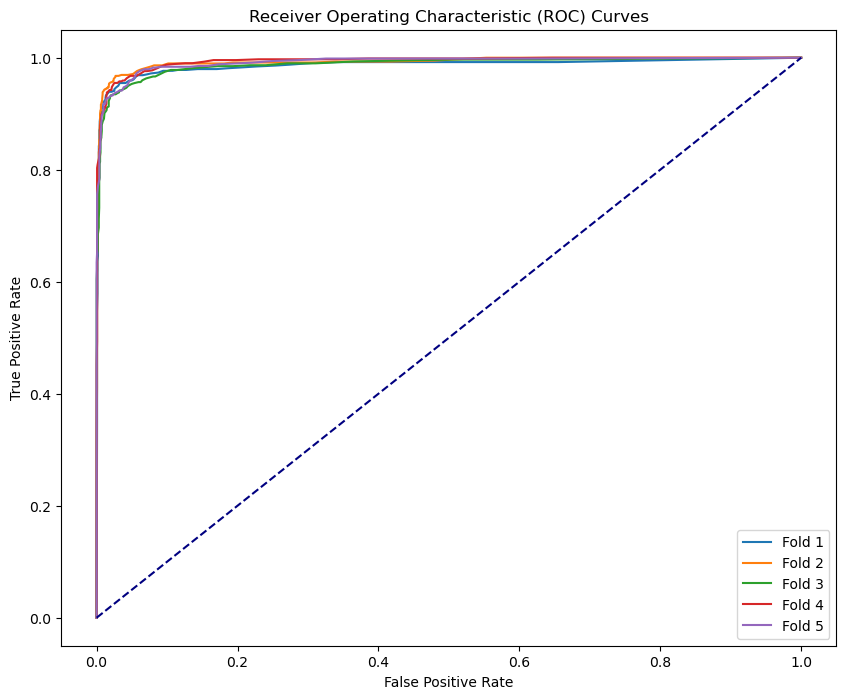

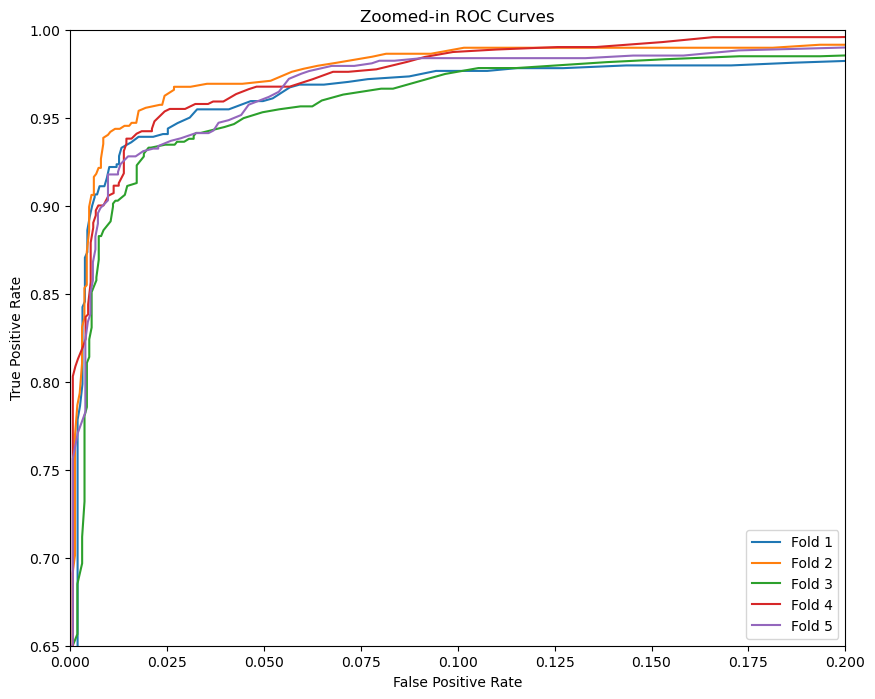

In [46]:
import matplotlib.pyplot as plt
import os

# Create the directory if it doesn't exist
directory = '../data/test/reports/figures/'
os.makedirs(directory, exist_ok=True)

# Plotting and saving the original plot
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the figure
plt.savefig(os.path.join(directory, 'ROC_Curves.png'))
plt.show()

# Plotting and saving the zoomed-in plot
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed-in ROC Curves')
plt.legend(loc="lower right")
plt.xlim([0, 0.2])  # Setting the x-axis limit for zooming in
plt.ylim([0.65, 1])  # Setting the y-axis limit for zooming in

# Save the zoomed-in figure
plt.savefig(os.path.join(directory, 'ROC_Curves_Zoomed.png'))
plt.show()


<Figure size 800x600 with 0 Axes>

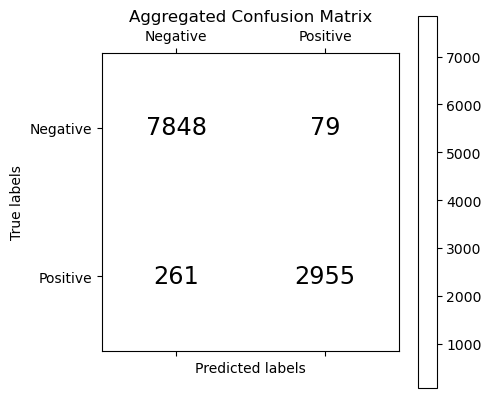

In [61]:
# Assuming metrics_df is your DataFrame with the metrics
total_tp = metrics_df['True Positives'].sum()
total_fp = metrics_df['False Positives'].sum()
total_tn = metrics_df['True Negatives'].sum()
total_fn = metrics_df['False Negatives'].sum()

import numpy as np
confusion_matrix = np.array([[total_tn, total_fp],
                             [total_fn, total_tp]])

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 6))
cmap = ListedColormap(['white'])

# Create the heatmap
plt.matshow(confusion_matrix, cmap=cmap)
plt.colorbar()

# Annotate the heatmap
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(x=j, y=i, s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')

# Add labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Save the figure
plt.savefig(os.path.join(directory, 'Aggregated_Confusion_Matrix.png'))

plt.show()


# Predict_model.py

## 6. Predicting new phages

- Input: trained_model picle + fasta/pharokka output
- Output: csv with predictions

In [13]:
print("--- Initiating prediction of the input data ---")
fasta_extensions = ["fasta", "fas", "fa", "fna", "ffn", "faa", "mpfa", "frn"]

def unix_call(command, environment=None):
    if environment:  # If the environment is specified, prepend with 'conda run -n env_name'
        command = f"conda run -n {environment} {command}"
    subprocess.run(command, shell=True, check=True)  

def run_pharokka(file_path, output_dir, database_dir):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    print(f"Running Pharokka on FASTA file: {file_path}")

    # Run Pharokka using the pharokkaENV environment
    # unix_call(f'pharokka.py -i {file_path} -o {output_dir} -f -m -t 16 -d {database_dir}', environment='pharokkaENV')



--- Initiating prediction of the input data ---


In [91]:
## Engineering features in the new data

args_data = '../data/interim/pharokka/10_folders/'  # Replace with your main folder path  # Replace with your main folder path
output_csv = '../data/test/test10_engineer_features.csv'
print("-> Starting Feature Engineering ----------------------")
# Delete the output CSV file if it already exists
if os.path.exists(output_csv):
    print("Output file already exists. Overwriting it...")
    os.remove(output_csv)
    
if os.path.isdir(args_data):
    print(f"Processing Pharokka phages in directory: {args_data}")
    process_pharokka_output(args_data, output_csv)
    
    # Print completion message
    print(f"Feature engineering completed for Prediction data and data stored to CSV in {output_csv}.")


elif os.path.isfile(args_data):
    # The input is a file; check if it's a FASTA file
    file_ext = os.path.splitext(args_data)[1][1:].lower()
    if file_ext in fasta_extensions:
        print("The processing of FASTA files with Pharokka is currently unavailable. Please, submit a folder with Pharokka outputs.")
        # run_pharokka(args_data, args_pharokka, args_database) 

        # # The input is a directory; process all relevant files within
        # print(f"Processing Pharokka output in directory: {args_pharokka}")
        # model_data = engineer_features(args_pharokka)


    else:
        print(f"Unsupported file format: {file_ext}. Supported FASTA formats are: {', '.join(fasta_extensions)}")
        exit(1)

else:
    print(f"The provided data path does not exist: {args_data}")
    exit(1)




-> Starting Feature Engineering ----------------------
The processing of FASTA files with Pharokka is currently unavailable. Please, submit a folder with Pharokka outputs.


In [31]:
model_data = pd.read_csv("../data/test/discarded.csv")

model_data = model_data.set_index(model_data.columns[0])

features = ['genome_length_inphared', 'gc_%_inphared',
       'cds_number_inphared', 'positive_strand_%_inphared',
       'negative_strand_%_inphared', 'coding_capacity_inphared',
       'tRNAs_inphared', 'molecule_inphared_type_DNA', 'topology_linear', 'jumbophage_inphared',
       'topology_circular', 'molecule_inphared_type_ss-DNA',
       'molecule_inphared_type_RNA', 'molecule_inphared_type_ss-RNA', 'length',
       'gc_perc', 'transl_table', 'cds_coding_density', 'CARD_AMR_Genes',
       'CDS', 'CRISPRs', 'VFDB_Virulence_Factors', 'connector',
       'head_packaging', 'host_takeover', 'integration and excision', 'lysis',
       'nucleotide_metabolism', 'other', 'tRNAs', 'tail', 'tmRNAs',
       'transcription', 'unkown_function', 'frame_positive', 'frame_negative']

model_data = model_data[features]

,genome_length_inphared,gc_%_inphared,cds_number_inphared,positive_strand_%_inphared,negative_strand_%_inphared,coding_capacity_inphared,tRNAs_inphared,molecule_inphared_type_DNA,topology_linear,jumbophage_inphared,...,lysis,nucleotide_metabolism,other,tRNAs,tail,tmRNAs,transcription,unkown_function,frame_positive,frame_negative
id,,,,,,,,,,,,,,,,,,,,,


In [88]:
args_model = "../data/test/model/model.pkl"
args_output = '../data/test/reports/'
# Making the prediction -----
import seaborn as sns
import warnings
# Load the model using the provided path
model = pickle.load(open(args_model, "rb"))

# Predictions
new_data_pred = model.predict(model_data)

# Get the probabilities for the predicted class for each instance
probas = model.predict_proba(model_data)
predicted_indices = np.argmax(probas, axis=1)  # Get index of max proba for each sample
new_data_pred_proba = [probas[i][predicted_indices[i]] for i in range(len(predicted_indices))]

# Prepare the output DataFrame
output_df = pd.DataFrame({
    'id': model_data.index,
    'prediction': new_data_pred,
    'prediction_probability': new_data_pred_proba
})

output_df = output_df.sort_values(by='prediction_probability', ascending=False)

csv_output_path = args_output + "predictions.csv"

# Uncomment the following line if you want to save the output to a CSV
output_df.to_csv(csv_output_path, index=False)

# python -m src.models.predict_model -d data/interim/genbank_engineering/50_sequences.gb

print()
print(f"The output has been saved in {csv_output_path}. The first 5 entries are: ")
print(output_df.head())



# KDE Plot
sns.set_style("whitegrid")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[df['prediction'] == 'positive']['prediction_probability'], fill=False, label='Positive', color="blue", clip=(0, 1))
    sns.kdeplot(df[df['prediction'] == 'negative']['prediction_probability'], fill=False, label='Negative', color="red", clip=(0, 1))
    sns.kdeplot(df['prediction_probability'], fill=False, label='Combined', color='grey', clip=(0, 1))
    plt.xlabel('Prediction Probability')
    plt.ylabel('Density')
    plt.title('Comparative Density of Positive and Negative Predictions')
    plt.legend()

    # Save KDE plot
    plt.tight_layout()
    plt.savefig(args_output + 'kde_plot.png')
    plt.close()

# Histogram Plot
sns.set_style("whitegrid")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    plt.figure(figsize=(10, 6))
    sns.histplot(df[df['prediction'] == 'positive']['prediction_probability'], kde=False, label='Positive', color="blue", bins=20)
    sns.histplot(df[df['prediction'] == 'negative']['prediction_probability'], kde=False, label='Negative', color="red", bins=20)
    sns.histplot(df['prediction_probability'], kde=False, label='Combined', color='grey', bins=20, alpha=0.3)
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()

    # Save histogram plot
    plt.tight_layout()
    plt.savefig(args_output + 'histogram_plot.png')
    plt.close()


The output has been saved in ../data/test/reports/predictions.csv. The first 5 entries are: 
            id prediction  prediction_probability
8469  AF274751   negative                     1.0
8023  KF765493   negative                     1.0
5731  MK514282   negative                     1.0
8028  JX080300   positive                     1.0
1731  OL617015   negative                     1.0
